# Knowledge graph experiment data generation

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_vocab = {idx: word for word, idx in vocab_to_idx.items()}

([50, 50, 50, 50, 50], [20, 29, 24, 26, 21])


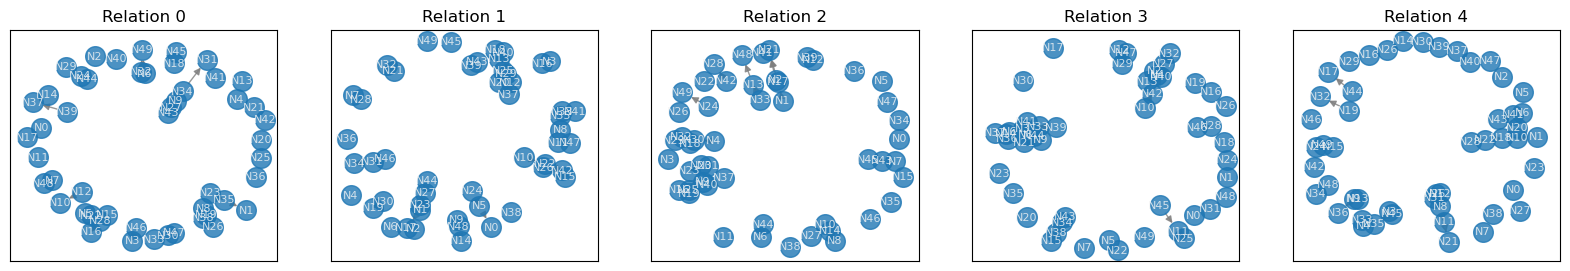

In [3]:
# randomly generate a graph with unique object for each (subject, relation) pair

def generate_graph(n_nodes, n_relations, p=1):
    graphs = [nx.DiGraph() for _ in range(n_relations)]
    for i in range(len(graphs)):
        graph = graphs[i]
        graph.add_nodes_from(node_vocab)
        for node in node_vocab:
            if np.random.rand() < p:
            # remove self loops
                obj_node = np.random.choice(node_vocab)
                if node != obj_node:
                    graph.add_edge(node, obj_node, relation=f'R{i}')
    return graphs

def draw_graph(graphs):    
    fig, axs = plt.subplots(ncols=n_relations, figsize=(4*n_relations,3))
    options = {"edge_color": "tab:gray", "node_size": 200, "alpha": 0.8, "node_color": "tab:blue", "font_color": "whitesmoke", "font_size": 8}
    for rel in range(n_relations):
        pos = nx.spring_layout(graphs[rel])
        
        nx.draw_networkx(graphs[rel], pos=pos, **options, ax=axs[rel])
        axs[rel].set_title(f"Relation {rel}")
    
graphs = generate_graph(50, n_relations, p=.5)
draw_graph(graphs)

# graph information
def get_graph_info(graphs):
    n_edges = [graph.number_of_edges() for graph in graphs]
    n_nodes = [graph.number_of_nodes() for graph in graphs]
    return n_nodes, n_edges
print(get_graph_info(graphs))


In [4]:
facts = {rel: list(graphs[rel].edges) for rel in range(n_relations)}
facts_all = [[fact[0], f'R{rel}', fact[1]] for rel in facts for fact in facts[rel]]

    

# generate context of true but irrelevant facts
def generate_pure_fact_example(fact, return_idx=True):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']
    fact = [vocab_to_idx[word] for word in fact] if return_idx else fact

    sequence = [ctx_start]

    sequence += [ctx_end, query_start]
    sequence += fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence

print(generate_pure_fact_example(facts_all[0], False))
facts_all = [generate_pure_fact_example(fact, True) for fact in facts_all]
print("Number of total facts:", len(facts_all))
print([idx_to_vocab[idx] for idx in facts_all[0]])


<CTX> </CTX> <QUERY> N5 R0 N22 </QUERY> <EOS>
Number of total facts: 120
['<CTX>', '</CTX>', '<QUERY>', 'N5', 'R0', 'N22', '</QUERY>', '<EOS>']


[[55, 56, 58, 5, 50, 22, 59, 60],
 [55, 56, 58, 6, 50, 49, 59, 60],
 [55, 56, 58, 7, 50, 48, 59, 60],
 [55, 56, 58, 8, 50, 19, 59, 60],
 [55, 56, 58, 9, 50, 34, 59, 60],
 [55, 56, 58, 12, 50, 10, 59, 60],
 [55, 56, 58, 15, 50, 28, 59, 60],
 [55, 56, 58, 19, 50, 38, 59, 60],
 [55, 56, 58, 23, 50, 35, 59, 60],
 [55, 56, 58, 24, 50, 44, 59, 60],
 [55, 56, 58, 27, 50, 9, 59, 60],
 [55, 56, 58, 28, 50, 16, 59, 60],
 [55, 56, 58, 32, 50, 49, 59, 60],
 [55, 56, 58, 34, 50, 31, 59, 60],
 [55, 56, 58, 35, 50, 1, 59, 60],
 [55, 56, 58, 38, 50, 26, 59, 60],
 [55, 56, 58, 39, 50, 37, 59, 60],
 [55, 56, 58, 43, 50, 27, 59, 60],
 [55, 56, 58, 46, 50, 3, 59, 60],
 [55, 56, 58, 47, 50, 30, 59, 60],
 [55, 56, 58, 1, 51, 17, 59, 60],
 [55, 56, 58, 2, 51, 17, 59, 60],
 [55, 56, 58, 5, 51, 0, 59, 60],
 [55, 56, 58, 9, 51, 48, 59, 60],
 [55, 56, 58, 10, 51, 22, 59, 60],
 [55, 56, 58, 11, 51, 47, 59, 60],
 [55, 56, 58, 12, 51, 29, 59, 60],
 [55, 56, 58, 13, 51, 18, 59, 60],
 [55, 56, 58, 15, 51, 42, 59, 60]

In [8]:
def sample_fact(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    fact_idx = np.random.choice(len(facts[rel]))
    fact = facts[rel][fact_idx]
    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]

def sample_falsehood(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)

    while True:
        # sample falsehood
        n1, n2 = np.random.choice(node_vocab, size=2)
        if (n1, n2) not in facts[rel]:
            break

    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


In [9]:
# generate context of true but irrelevant facts
def generate_robustness_example(context_length, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_fact(return_idx=return_idx)

    for i in range(context_length):
        # NOTE: for now, not checking if irrelevant; sampling randomly so most likely irrelevant
        ctx_fact = sample_fact(return_idx=return_idx)
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [10]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_robustness_example(3, return_idx=False))

<CTX> N41 R3 N3 <SEP> N32 R2 N29 <SEP> N46 R3 N28 <SEP> </CTX> <QUERY> N13 R4 N9 </QUERY> <EOS>
<CTX> N33 R2 N13 <SEP> N28 R0 N16 <SEP> N13 R1 N18 <SEP> </CTX> <QUERY> N34 R0 N31 </QUERY> <EOS>
<CTX> N43 R0 N27 <SEP> N44 R1 N27 <SEP> N24 R1 N5 <SEP> </CTX> <QUERY> N35 R0 N1 </QUERY> <EOS>
<CTX> N9 R3 N44 <SEP> N45 R3 N11 <SEP> N13 R3 N2 <SEP> </CTX> <QUERY> N24 R2 N49 </QUERY> <EOS>
<CTX> N15 R4 N24 <SEP> N29 R1 N40 <SEP> N15 R1 N42 <SEP> </CTX> <QUERY> N45 R2 N7 </QUERY> <EOS>


In [11]:
# query is inconsistent with world knowledge
def generate_controllability_example(context_length, insert_pos=None, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_falsehood(return_idx=return_idx)

    contexts = []
    for i in range(context_length-1):
        ctx_fact = sample_fact(return_idx=return_idx)
        contexts.append(ctx_fact)

    # insert query fact at random position of context to test controllability
    if insert_pos is None:
        insert_pos = np.random.randint(context_length)
    contexts.insert(insert_pos, query_fact)

    for ctx_fact in contexts:
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [12]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_controllability_example(3, return_idx=False))

<CTX> N4 R4 N17 <SEP> N39 R3 N33 <SEP> N40 R2 N25 <SEP> </CTX> <QUERY> N4 R4 N17 </QUERY> <EOS>
<CTX> N19 R0 N38 <SEP> N23 R2 N23 <SEP> N4 R2 N30 <SEP> </CTX> <QUERY> N23 R2 N23 </QUERY> <EOS>
<CTX> N33 R2 N13 <SEP> N35 R2 N41 <SEP> N12 R2 N39 <SEP> </CTX> <QUERY> N35 R2 N41 </QUERY> <EOS>
<CTX> N27 R0 N9 <SEP> N9 R2 N46 <SEP> N34 R0 N31 <SEP> </CTX> <QUERY> N9 R2 N46 </QUERY> <EOS>
<CTX> N4 R2 N30 <SEP> N26 R3 N28 <SEP> N10 R4 N1 <SEP> </CTX> <QUERY> N26 R3 N28 </QUERY> <EOS>


In [13]:
# print some examples of robustness examples (print token idx)
for _ in range(5):
    print(generate_controllability_example(3, return_idx=True))

[55, 39, 52, 25, 57, 2, 52, 21, 57, 38, 50, 26, 57, 56, 58, 39, 52, 25, 59, 60]
[55, 45, 52, 7, 57, 14, 50, 15, 57, 21, 51, 32, 57, 56, 58, 14, 50, 15, 59, 60]
[55, 45, 52, 25, 57, 43, 52, 7, 57, 22, 54, 18, 57, 56, 58, 45, 52, 25, 59, 60]
[55, 7, 50, 48, 57, 20, 51, 13, 57, 42, 53, 22, 57, 56, 58, 42, 53, 22, 59, 60]
[55, 40, 53, 27, 57, 21, 51, 32, 57, 45, 52, 4, 57, 56, 58, 45, 52, 4, 59, 60]


In [14]:
# pre-training: "robustness" context_length=0

# training
# w.p. 1/3
# just facts: "robustness" with context_length=0
# w.p. 1/3
# robustness: uniformly context_length=1,2,3
# w.p. 1/3
# controllability: uniformly context_length=1,2,3

# validation
# same but separate context_lengths to different datasets to compute separate metrics

In [15]:
def pad_truncate(sequence, max_length):
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    elif len(sequence) < max_length:
        sequence += [vocab_to_idx['<PAD>']] * (max_length - len(sequence))

    return sequence

## Create training dataset

In [16]:
# create train_ds
n_examples = 3000 # total number of examples

p_facts = 1/3 # proportion of facts
p_robustness = 1/3 # proportion of robustness
p_controllability = 1/3 # proportion of controllability
assert (p_facts + p_robustness + p_controllability) == 1 # make sure this makes sense

max_context_statements = 3 # maximum number of context facts; sample uniformly from 1,2,3
max_block_length = len(generate_robustness_example(3, return_idx=True)) # get the block length of the longest example

n_facts = int(n_examples * p_facts)
n_robustness = int(n_examples * p_robustness)
n_controllability = int(n_examples * p_controllability)

In [17]:
# create pure fact train_ds_fact for pretraining
max_length = len(facts_all[0]) # get the block length of the longest example

train_data_fact = [pad_truncate(fact, max_length) for fact in facts_all]
train_data_fact

[[55, 56, 58, 5, 50, 22, 59, 60],
 [55, 56, 58, 6, 50, 49, 59, 60],
 [55, 56, 58, 7, 50, 48, 59, 60],
 [55, 56, 58, 8, 50, 19, 59, 60],
 [55, 56, 58, 9, 50, 34, 59, 60],
 [55, 56, 58, 12, 50, 10, 59, 60],
 [55, 56, 58, 15, 50, 28, 59, 60],
 [55, 56, 58, 19, 50, 38, 59, 60],
 [55, 56, 58, 23, 50, 35, 59, 60],
 [55, 56, 58, 24, 50, 44, 59, 60],
 [55, 56, 58, 27, 50, 9, 59, 60],
 [55, 56, 58, 28, 50, 16, 59, 60],
 [55, 56, 58, 32, 50, 49, 59, 60],
 [55, 56, 58, 34, 50, 31, 59, 60],
 [55, 56, 58, 35, 50, 1, 59, 60],
 [55, 56, 58, 38, 50, 26, 59, 60],
 [55, 56, 58, 39, 50, 37, 59, 60],
 [55, 56, 58, 43, 50, 27, 59, 60],
 [55, 56, 58, 46, 50, 3, 59, 60],
 [55, 56, 58, 47, 50, 30, 59, 60],
 [55, 56, 58, 1, 51, 17, 59, 60],
 [55, 56, 58, 2, 51, 17, 59, 60],
 [55, 56, 58, 5, 51, 0, 59, 60],
 [55, 56, 58, 9, 51, 48, 59, 60],
 [55, 56, 58, 10, 51, 22, 59, 60],
 [55, 56, 58, 11, 51, 47, 59, 60],
 [55, 56, 58, 12, 51, 29, 59, 60],
 [55, 56, 58, 13, 51, 18, 59, 60],
 [55, 56, 58, 15, 51, 42, 59, 60]

In [19]:
train_data = []

for _ in trange(n_facts):
    example = generate_robustness_example(0, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_robustness):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    example = generate_robustness_example(n_context_statements, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_controllability):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    insert_pos = np.random.randint(n_context_statements)
    example = generate_controllability_example(n_context_statements, insert_pos=insert_pos, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)


100%|██████████| 1000/1000 [00:00<00:00, 24575.95it/s]


In [20]:
# create and save
train_ds_tensor = torch.tensor(train_data, dtype=torch.int64)
# np.random.shuffle(train_ds)
torch.save(train_ds_tensor, '../data/knowledge_graph/knowledge_graph_train_ds.pt')

train_ds_fact_tensor = torch.tensor(train_data_fact, dtype=torch.int64)
torch.save(train_ds_fact_tensor, '../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')

In [21]:
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds_fact_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')

In [22]:
def generate_val_data(type, n_context_statements, n_examples, max_block_length=max_block_length):
    example_generator = generate_robustness_example if type == 'robustness' else generate_controllability_example
    val_data = []
    for _ in trange(n_examples):
        example = example_generator(n_context_statements, return_idx=True)
        example = pad_truncate(example, max_block_length)
        val_data.append(example)

    return torch.tensor(val_data)


In [23]:
for type in ['robustness', 'controllability']:
    for n_context_statements in range(1, max_context_statements+1):
        n_examples = 1_000
        val_data = generate_val_data(type, n_context_statements, n_examples)
        torch.save(val_data, f'../data/knowledge_graph/knowledge_graph_val_ds_{type}_{n_context_statements}.pt')

100%|██████████| 1000/1000 [00:00<00:00, 19605.60it/s]


### Demo on how to load data

In [24]:
# how to load data and createe data loader
import sys; sys.path.append('../')
from data_utils import LanguageModelTensorDataset
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

In [25]:
# some examples from train_ds_tensor
for x in train_ds_tensor[:50]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[55, 56, 58, 14, 53, 37, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N14 R3 N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 2, 52, 21, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N2 R2 N21 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 35, 50, 1, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N35 R0 N1 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 2, 53, 27, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N2 R3 N27 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 44, 54, 17, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N44 R4 N17 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[

In [26]:
# some examples from train__ds_tensor
for x in train_ds_fact_tensor[:5]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[55, 56, 58, 5, 50, 22, 59, 60]
<CTX> </CTX> <QUERY> N5 R0 N22 </QUERY> <EOS>

[55, 56, 58, 6, 50, 49, 59, 60]
<CTX> </CTX> <QUERY> N6 R0 N49 </QUERY> <EOS>

[55, 56, 58, 7, 50, 48, 59, 60]
<CTX> </CTX> <QUERY> N7 R0 N48 </QUERY> <EOS>

[55, 56, 58, 8, 50, 19, 59, 60]
<CTX> </CTX> <QUERY> N8 R0 N19 </QUERY> <EOS>

[55, 56, 58, 9, 50, 34, 59, 60]
<CTX> </CTX> <QUERY> N9 R0 N34 </QUERY> <EOS>



In [27]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

INPUT
[55, 22, 54, 18, 57, 5, 51, 0, 57, 44, 52, 6, 57, 56, 58, 2, 52, 21, 59]
<CTX> N22 R4 N18 <SEP> N5 R1 N0 <SEP> N44 R2 N6 <SEP> </CTX> <QUERY> N2 R2 N21 </QUERY>
TARGET
[22, 54, 18, 57, 5, 51, 0, 57, 44, 52, 6, 57, 56, 58, 2, 52, 21, 59, 60]
N22 R4 N18 <SEP> N5 R1 N0 <SEP> N44 R2 N6 <SEP> </CTX> <QUERY> N2 R2 N21 </QUERY> <EOS>
----------------------------------------------------------------------------------------------------

INPUT
[55, 35, 54, 4, 57, 44, 53, 8, 57, 56, 58, 13, 52, 48, 59, 60, 61, 61, 61]
<CTX> N35 R4 N4 <SEP> N44 R3 N8 <SEP> </CTX> <QUERY> N13 R2 N48 </QUERY> <EOS> <PAD> <PAD> <PAD>
TARGET
[35, 54, 4, 57, 44, 53, 8, 57, 56, 58, 13, 52, 48, 59, 60, 61, 61, 61, 61]
N35 R4 N4 <SEP> N44 R3 N8 <SEP> </CTX> <QUERY> N13 R2 N48 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 56, 58, 12, 50, 10, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> 